In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from IPython.core.display import display, HTML; display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import os, sys, time, pickle, functools
import utils, optimization, metrics, plot, data, evaluation

import plot
from plot import get_animation, save_animation

from model import WGanModel, LapGanModel
from gan import CosmoGAN, UpscaleCosmoGAN
import blocks
from blocks import *

import sys
sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import os
import data, utils
from model import upscale_WGAN_pixel_CNN, WGanModel
from gan import CosmoGAN

Populating the interactive namespace from numpy and matplotlib


/home/ankit/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
try_resume = True
Mpch = 350
ln_fwd = data.fmap.log_norm_forward
ln_bkd = data.fmap.log_norm_backward

l_fwd = data.fmap.forward
l_bkd = data.fmap.backward

# 32 -> 64

# log_norm

In [3]:
real_ln_64 = data.load.load_dataset_file(spix=64, resolution=256, Mpch=350, scaling=4, augmentation=False, shuffle=False, forward_map=ln_fwd, is_3d=True).get_all_data()
real_ln_64_raw = ln_bkd(real_ln_64)
print("Real shape: ", np.shape(real_ln_64))

downsampled_ln_32 = np.expand_dims(blocks.downsample(real_ln_64[:2, :, :, :], s=2, is_3d=True), axis=4)
downsampled_ln_32_raw = np.squeeze(ln_bkd(downsampled_ln_32))
print('downsampled_ln_32 shape=', downsampled_ln_32.shape)

Loaded all 2 histograms only once in the beginning!
Tensor down_sampler_out_3d_4:0 not found, hence creating the Op.
Real shape:  (2, 64, 64, 64)
Tensor down_sampler_out_3d_2:0 not found, hence creating the Op.
downsampled_ln_32 shape= (2, 32, 32, 32, 1)


In [4]:
#time_str = 'log_norm_c_8k'
time_str = 'log_norm'
#global_path = '../../up_scale_GAN_results/upscaling_GAN_3d/log_norm_zero_origin/inception_32_to_64_log_norm_c_8k/'
global_path = '../../up_scale_GAN_results/upscaling_GAN_3d/final/resnet_32_to_64_log_norm/'
name = 'resnet_32_to_64'
#name = 'resnet_inception_32_to_64'

params_64 = dict()
params_64['save_dir'] = global_path + name + '_' + time_str + 'checkpoints/'

resume_64, params_64 = utils.test_resume(try_resume, params_64)
#for ind, item in enumerate(params_64.items()):
#    print(ind, " : ", item[0], " - ", item[1])
print(params_64['curr_counter'])

params_64['summary_dir'] = global_path + params_64['name'] + '_' + time_str +'summary/'
params_64['save_dir'] = global_path + params_64['name'] + '_' + time_str + 'checkpoints/'
#params_64['cosmology']['forward_map'] = ln_fwd
#params_64['cosmology']['backward_map'] = ln_bkd

print(params_64['summary_dir'])
print(params_64['save_dir'])

Resume, the training will start from the last iteration!
87000
../../up_scale_GAN_results/upscaling_GAN_3d/final/resnet_32_to_64_log_norm/resnet_32_to_64_log_normsummary/
../../up_scale_GAN_results/upscaling_GAN_3d/final/resnet_32_to_64_log_norm/resnet_32_to_64_log_normcheckpoints/


In [6]:
wgan_64 = UpscaleCosmoGAN(params_64, upscale_WGAN_pixel_CNN, is_3d=True)
fake_ln_64 = wgan_64.upscale_image(small=downsampled_ln_32, checkpoint=None)
utils.save_hdf5(fake_ln_64, 'Samples/final/resnet_32_to_64_log_norm/2_64_samples_ckpt_87k_real.h5')

Generator 
--------------------------------------------------
     The input X is of size (?, 16, 16, 16, 1)
     The input X is upsampled to size (?, 32, 32, 32, 1)
     The input z is of size (?, 32768)
     The input y is of size (?, 32, 32, 32, 7)
     Reshape z to (?, 32, 32, 32, 1)
     Concat X and z to (?, 32, 32, 32, 2)
     conv_over_deconv= True
     Merge input y of size(?, 32, 32, 32, 7)
     Concat x and y to (?, 32, 32, 32, 9)
     0 Inception conv(1x1,3x3,5x5) layer with 64 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 64)
     1 Inception conv(1x1,3x3,5x5) layer with 64 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 64)
     2 Inception conv(1x1,3x3,5x5) layer with 64 channels
         Residual connection
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 64)
     3 Inception conv(1x1,3x3,5x5) layer with 64 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 6

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../up_scale_GAN_results/upscaling_GAN_3d/final/resnet_32_to_64_log_norm/resnet_32_to_64_log_normcheckpoints/resnet_32_to_64-87000
Checkpoint successfully loaded!
Total number of patches = 2*2*2 = 8
Current patch: column=1, row=1, height=1

Current patch: column=2, row=1, height=1

Current patch: column=1, row=2, height=1

Current patch: column=2, row=2, height=1

Current patch: column=1, row=1, height=2

Current patch: column=2, row=1, height=2

Current patch: column=1, row=2, height=2

Current patch: column=2, row=2, height=2



In [7]:
fake_ln_64 = utils.load_hdf5('Samples/final/resnet_32_to_64_log_norm/2_64_samples_ckpt_87k_real.h5')
fake_ln_64_raw = ln_bkd(fake_ln_64)
print('gen_samples_64 shape=', fake_ln_64.shape)

gen_samples_64 shape= (2, 64, 64, 64)


[MoviePy] >>>> Building video Samples/final/resnet_32_to_64_log_norm/0th_64_samples_ckpt_87k_real.mp4
[MoviePy] Writing video Samples/final/resnet_32_to_64_log_norm/0th_64_samples_ckpt_87k_real.mp4


 98%|█████████▊| 64/65 [00:31<00:00,  2.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Samples/final/resnet_32_to_64_log_norm/0th_64_samples_ckpt_87k_real.mp4 



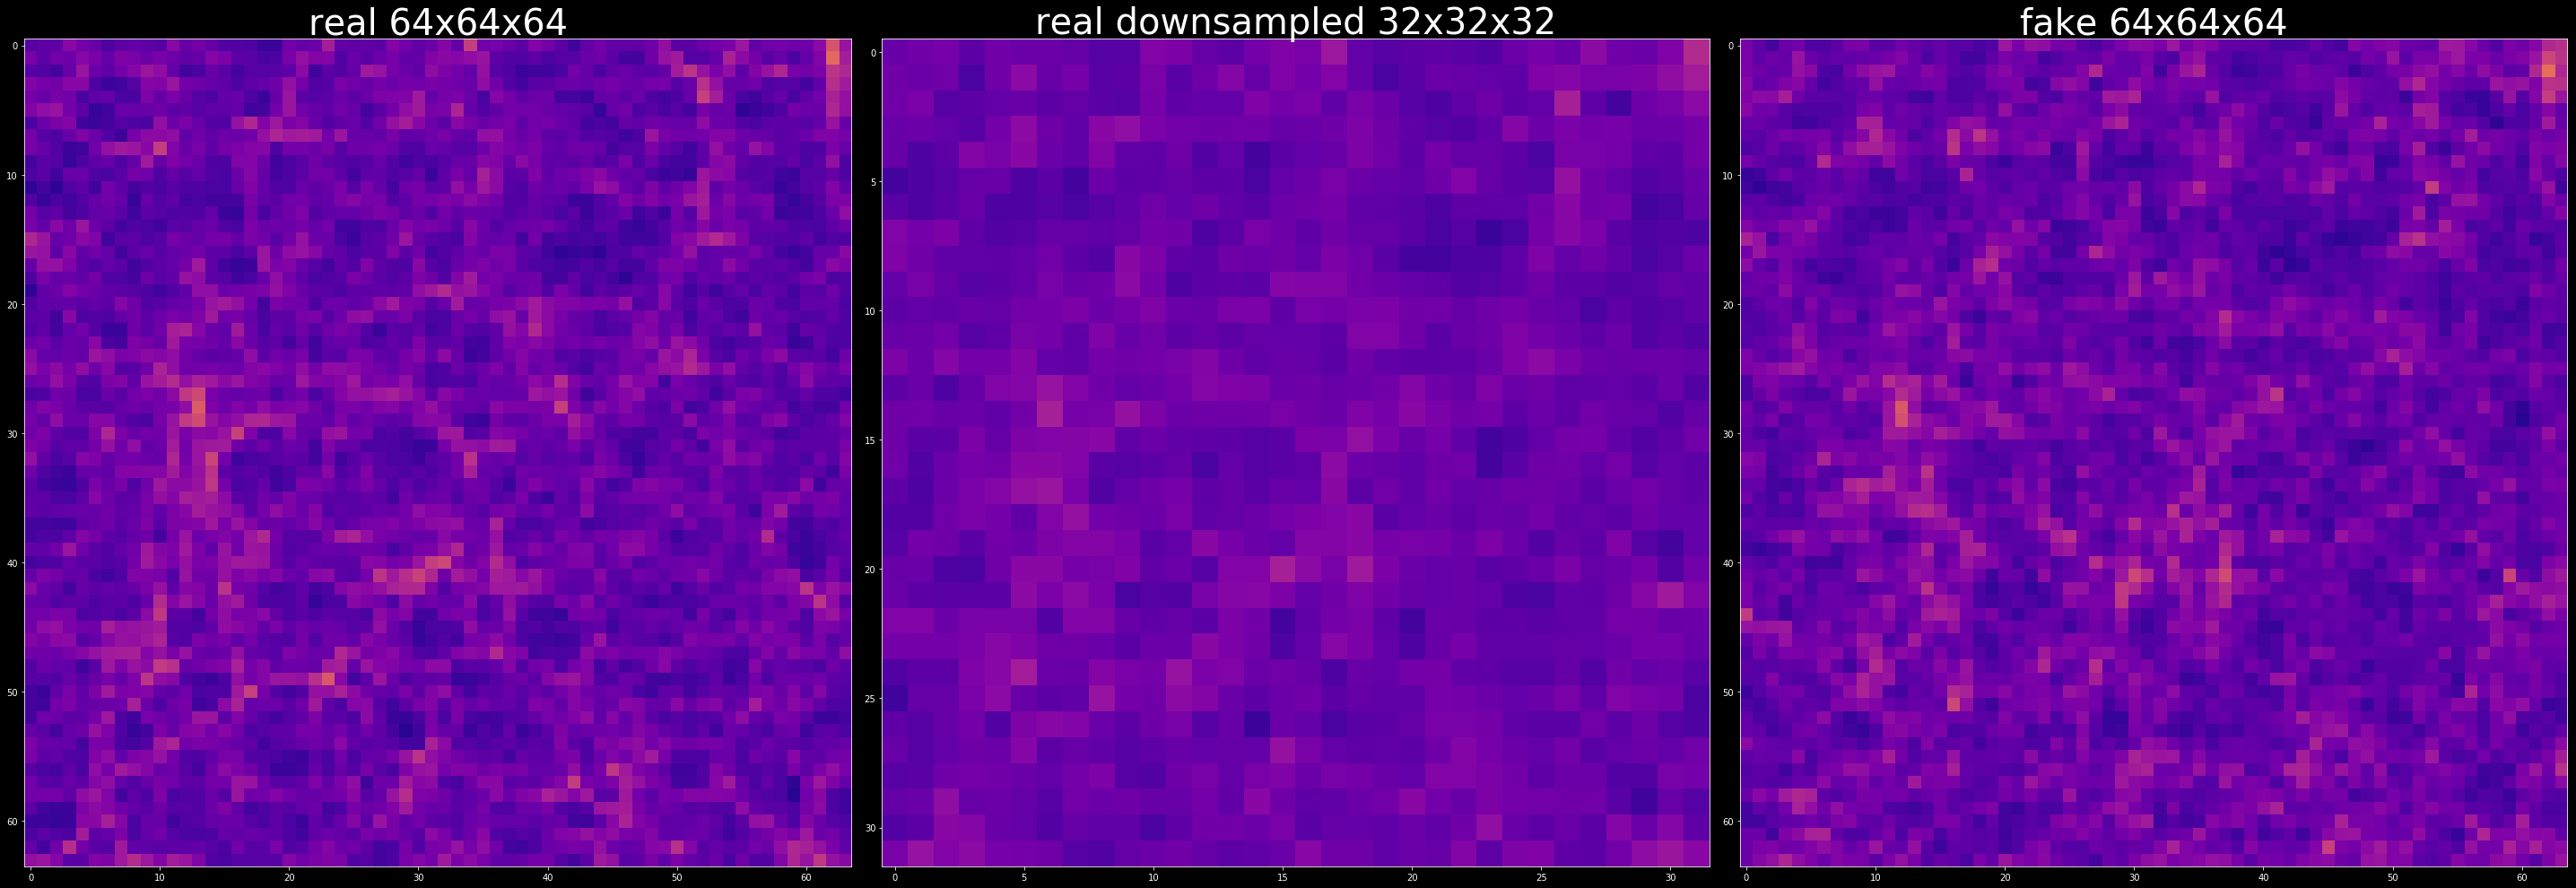

In [8]:
fake = l_fwd(fake_ln_64_raw[0, :, :, :])
real = l_fwd(real_ln_64_raw[0, :, :, :])
down = l_fwd(downsampled_ln_32_raw[0, :, :, :])
#get_animation(real, fake, down, figsize=(15, 15), fps=5).ipython_display(fps=5, loop=True, autoplay=True)
save_animation(real, fake, down, figsize=(40, 20), fps=16, format='mp4', output_file_name='Samples/final/resnet_32_to_64_log_norm/0th_64_samples_ckpt_87k_real.mp4', fontsize=40)

Log l2 PSD loss: 2.774980112422344
L2 PSD loss: 2859.0579043619105
Log l1 PSD loss: 1.296236004513927
L1 PSD loss: 24.943841782097547


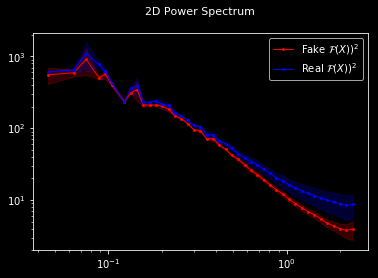

In [9]:
logl2, l2, logl1, l1 = evaluation.compute_and_plot_psd(real_ln_64_raw, fake_ln_64_raw, is_3d=True)

Log l2 Peak Count loss: 54.232016997687424
L2 Peak Count loss: 340.225
Log l1 Peak Count loss: 3.9377484002220755
L1 Peak Count loss: 10.0


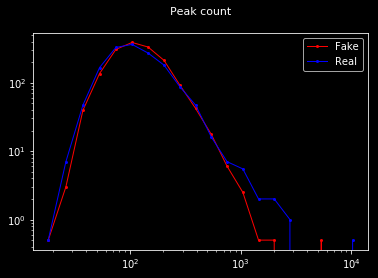

In [10]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_ln_64_raw, fake_ln_64_raw)

Log l2 Mass histogram loss: 33.38804774392528
L2 Peak Mass histogram: 1433508.525
Log l1 Mass histogram loss: 2.610955391556222
L1 Mass histogram loss: 535.0


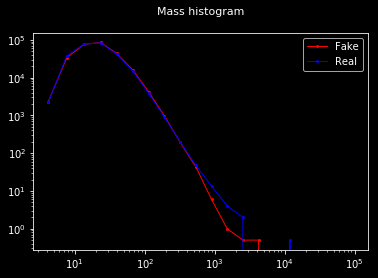

In [11]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_ln_64_raw, fake_ln_64_raw)

# log

In [3]:
real_l_64 = data.load.load_dataset_file(spix=64, resolution=256, Mpch=350, scaling=4, augmentation=False, shuffle=False, forward_map=l_fwd, is_3d=True).get_all_data()
real_l_64_raw = l_bkd(real_l_64)
print("Real shape: ", np.shape(real_l_64))

downsampled_l_32 = np.expand_dims(blocks.downsample(real_l_64[:2, :, :, :], s=2, is_3d=True), axis=4)
print('downsampled_l_32 shape=', downsampled_l_32.shape)

Loaded all 2 histograms only once in the beginning!
Tensor down_sampler_out_3d_4:0 not found, hence creating the Op.
Real shape:  (2, 64, 64, 64)
Tensor down_sampler_out_3d_2:0 not found, hence creating the Op.
downsampled_l_32 shape= (2, 32, 32, 32, 1)


In [4]:
time_str = 'upscaling_GAN_3d_gen_8_disc_6_32_new_trans'
global_path = '../../up_scale_GAN_results/upscaling_GAN_3d/bigstat/inception_32_to_64_upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/'
name = 'inception_32_to_64_upsampled_upscaling_GAN_3d_32'

params_64 = dict()
params_64['save_dir'] = global_path + name + '_' + time_str + 'checkpoints/'

resume_64, params_64 = utils.test_resume(try_resume, params_64)
print(params_64['curr_counter'])

params_64['summary_dir'] = global_path + params_64['name'] + '_' + time_str +'summary/'
params_64['save_dir'] = global_path + params_64['name'] + '_' + time_str + 'checkpoints/'

print(params_64['summary_dir'])
print(params_64['save_dir'])

Resume, the training will start from the last iteration!
120000
../../up_scale_GAN_results/upscaling_GAN_3d/bigstat/inception_32_to_64_upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/inception_32_to_64_upsampled_upscaling_GAN_3d_32_upscaling_GAN_3d_gen_8_disc_6_32_new_transsummary/
../../up_scale_GAN_results/upscaling_GAN_3d/bigstat/inception_32_to_64_upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/inception_32_to_64_upsampled_upscaling_GAN_3d_32_upscaling_GAN_3d_gen_8_disc_6_32_new_transcheckpoints/


In [5]:
wgan_64 = UpscaleCosmoGAN(params_64, upscale_WGAN_pixel_CNN, is_3d=True)
fake_l_64 = wgan_64.upscale_image(small=downsampled_l_32, is_3d=True, checkpoint=None)
utils.save_hdf5(fake_l_64, 'Samples/bigstat/inception_32_to_64_upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/2_64_samples_ckpt_120k_real.h5')

Generator 
--------------------------------------------------
     The input X is of size (?, 16, 16, 16, 1)
     The input X is upsampled to size (?, 32, 32, 32, 1)
     The input z is of size (?, 32768)
     The input y is of size (?, 32, 32, 32, 7)
     Reshape z to (?, 32, 32, 32, 1)
     Concat X and z to (?, 32, 32, 32, 2)
     Merge input y of size(?, 32, 32, 32, 7)
     Concat x and y to (?, 32, 32, 32, 9)
     0 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 96)
     1 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 96)
     2 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 192)
     3 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 192)
     4 Inception deconv(1x1,3x3,5x5) layer w

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../up_scale_GAN_results/upscaling_GAN_3d/bigstat/inception_32_to_64_upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/inception_32_to_64_upsampled_upscaling_GAN_3d_32_upscaling_GAN_3d_gen_8_disc_6_32_new_transcheckpoints/inception_32_to_64_upsampled_upscaling_GAN_3d_32-120000
Checkpoint successfully loaded!
Total number of patches = 2*2*2 = 8
downsampled: min=0.24747636914253235 max=1.100386381149292
Current patch: column=1, row=1, height=1
gen_sample: min=0.09473243355751038 max=1.713759183883667


downsampled: min=0.22297543287277222 max=1.245916724205017
Current patch: column=2, row=1, height=1
gen_sample: min=0.08504489064216614 max=1.6626629829406738


downsampled: min=0.2708999514579773 max=1.0919387340545654
Current patch: column=1, row=2, height=1
gen_sample: min=0.08266386389732361 max=1.5635192394256592


downsampled: min=0.25997868180274963 max=1.1376562118530273
Current patch: column=2, row=2, heigh

In [7]:
fake_l_64 = utils.load_hdf5('Samples/bigstat/inception_32_to_64_upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/2_64_samples_ckpt_120k_real.h5')
fake_l_64_raw = l_bkd(fake_l_64)
print('fake_l_64 shape=', fake_l_64.shape)

fake_l_64 shape= (2, 64, 64, 64)


 98%|█████████▊| 60/61 [00:05<00:00, 11.10it/s]


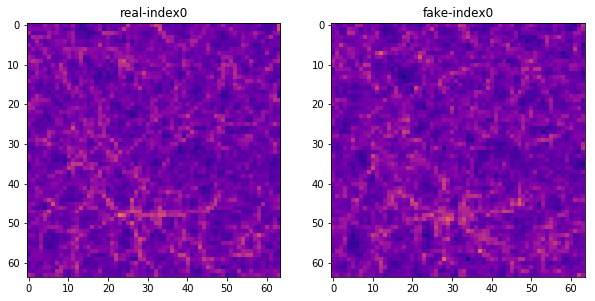

In [8]:
fake = fake_l_64[0, :, :, :]
real = real_l_64[0, :, :, :]
get_animation(real, fake, figsize=(10, 10), fps=5).ipython_display(fps=5, loop=True, autoplay=True)

Log l2 PSD loss: 0.3637810746031703
L2 PSD loss: 2058.5453536335003
Log l1 PSD loss: 0.5369443888196256
L1 PSD loss: 20.70929893879466


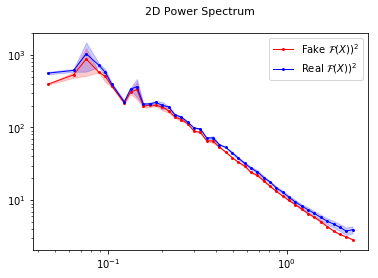

In [9]:
logl2, l2, logl1, l1 = evaluation.compute_and_plot_psd(real_l_64_raw, fake_l_64_raw, is_3d=True)

Log l2 Peak Count loss: 36.37732731897554
L2 Peak Count loss: 252.675
Log l1 Peak Count loss: 2.7541800280626743
L1 Peak Count loss: 9.8


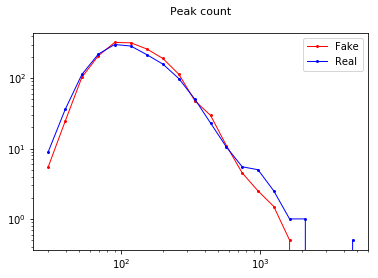

In [10]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_l_64_raw, fake_l_64_raw)

Log l2 Mass histogram loss: 35.814035857423505
L2 Peak Mass histogram: 423310.6125
Log l1 Mass histogram loss: 2.3657066768745416
L1 Mass histogram loss: 358.925


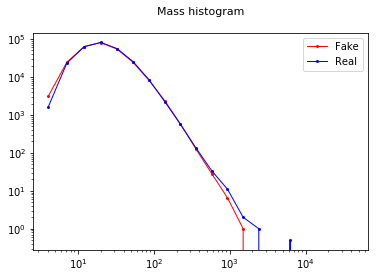

In [11]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_l_64_raw, fake_l_64_raw)

# 64->256

# log_norm

In [7]:
real_ln_256 = data.load.load_dataset_file(spix=256, resolution=256, Mpch=350, augmentation=False, shuffle=False, forward_map=ln_fwd, is_3d=True).get_all_data()
real_ln_256_raw = ln_bkd(real_ln_256)
print("Real shape: ", np.shape(real_ln_256))

downsampled_ln_256 = np.expand_dims(blocks.downsample(real_ln_256[:2, :, :, :], s=4, is_3d=True), axis=4)
downsampled_ln_256_raw = np.squeeze(ln_bkd(downsampled_ln_256))
print('downsampled_ln_256 shape=', downsampled_ln_256.shape)

Loaded all 2 histograms only once in the beginning!
Real shape:  (2, 256, 256, 256)
downsampled_ln_256 shape= (2, 64, 64, 64, 1)


In [8]:
time_str = 'log_norm'
global_path = '../../up_scale_GAN_results/upscaling_GAN_3d/final/resnet_64_to_256_log_norm/'
name = 'resnet_64_to_256'

params_256 = dict()
params_256['save_dir'] = global_path + name + '_' + time_str + 'checkpoints/'

resume, params_256 = utils.test_resume(try_resume, params_256)
print(params_256['curr_counter'])

params_256['summary_dir'] = global_path + params_256['name'] + '_' + time_str +'summary/'
params_256['save_dir'] = global_path + params_256['name'] + '_' + time_str + 'checkpoints/'
params_256['cosmology']['forward_map'] = ln_fwd
params_256['cosmology']['backward_map'] = ln_bkd

Resume, the training will start from the last iteration!
116000


In [22]:
wgan_256 = UpscaleCosmoGAN(params_256, upscale_WGAN_pixel_CNN, is_3d=True)
fake_ln_256 = wgan_256.upscale_image(small=downsampled_ln_256, is_3d=True, checkpoint=None)
utils.save_hdf5(fake_ln_256, 'Samples/final/resnet_64_to_256_log_norm/2_256_samples_ckpt_116k_real.h5')

Generator 
--------------------------------------------------
     The input X is of size (?, 8, 8, 8, 1)
     The input X is upsampled to size (?, 32, 32, 32, 1)
     The input z is of size (?, 32768)
     The input y is of size (?, 32, 32, 32, 7)
     Reshape z to (?, 32, 32, 32, 1)
     Concat X and z to (?, 32, 32, 32, 2)
     conv_over_deconv= True
     Merge input y of size(?, 32, 32, 32, 7)
     Concat x and y to (?, 32, 32, 32, 9)
     0 Inception conv(1x1,3x3,5x5) layer with 32 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 32)
     1 Inception conv(1x1,3x3,5x5) layer with 32 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 32)
     2 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Residual connection
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 32)
     3 Inception conv(1x1,3x3,5x5) layer with 32 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 32)


 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../up_scale_GAN_results/upscaling_GAN_3d/final/resnet_64_to_256_log_norm/resnet_64_to_256_log_normcheckpoints/resnet_64_to_256-116000
Checkpoint successfully loaded!
Total number of patches = 8*8*8 = 512
Current patch: column=1, row=1, height=1

Current patch: column=2, row=1, height=1

Current patch: column=3, row=1, height=1

Current patch: column=4, row=1, height=1

Current patch: column=5, row=1, height=1

Current patch: column=6, row=1, height=1

Current patch: column=7, row=1, height=1

Current patch: column=8, row=1, height=1

Current patch: column=1, row=2, height=1

Current patch: column=2, row=2, height=1

Current patch: column=3, row=2, height=1

Current patch: column=4, row=2, height=1

Current patch: column=5, row=2, height=1

Current patch: column=6, row=2, height=1

Current patch: column=7, row=2, height=1

Current patch: column=8, row=2, height=1

Current patch: column=1, row=3, height=1

Current p

Current patch: column=6, row=8, height=3

Current patch: column=7, row=8, height=3

Current patch: column=8, row=8, height=3

Current patch: column=1, row=1, height=4

Current patch: column=2, row=1, height=4

Current patch: column=3, row=1, height=4

Current patch: column=4, row=1, height=4

Current patch: column=5, row=1, height=4

Current patch: column=6, row=1, height=4

Current patch: column=7, row=1, height=4

Current patch: column=8, row=1, height=4

Current patch: column=1, row=2, height=4

Current patch: column=2, row=2, height=4

Current patch: column=3, row=2, height=4

Current patch: column=4, row=2, height=4

Current patch: column=5, row=2, height=4

Current patch: column=6, row=2, height=4

Current patch: column=7, row=2, height=4

Current patch: column=8, row=2, height=4

Current patch: column=1, row=3, height=4

Current patch: column=2, row=3, height=4

Current patch: column=3, row=3, height=4

Current patch: column=4, row=3, height=4

Current patch: column=5, row=3, he

Current patch: column=2, row=1, height=7

Current patch: column=3, row=1, height=7

Current patch: column=4, row=1, height=7

Current patch: column=5, row=1, height=7

Current patch: column=6, row=1, height=7

Current patch: column=7, row=1, height=7

Current patch: column=8, row=1, height=7

Current patch: column=1, row=2, height=7

Current patch: column=2, row=2, height=7

Current patch: column=3, row=2, height=7

Current patch: column=4, row=2, height=7

Current patch: column=5, row=2, height=7

Current patch: column=6, row=2, height=7

Current patch: column=7, row=2, height=7

Current patch: column=8, row=2, height=7

Current patch: column=1, row=3, height=7

Current patch: column=2, row=3, height=7

Current patch: column=3, row=3, height=7

Current patch: column=4, row=3, height=7

Current patch: column=5, row=3, height=7

Current patch: column=6, row=3, height=7

Current patch: column=7, row=3, height=7

Current patch: column=8, row=3, height=7

Current patch: column=1, row=4, he

In [9]:
fake_ln_256 = utils.load_hdf5('Samples/final/resnet_64_to_256_log_norm/2_256_samples_ckpt_116k_real.h5')
fake_ln_256_raw = ln_bkd(fake_ln_256)

duration= 16
[MoviePy] >>>> Building video Samples/final/resnet_64_to_256_log_norm/1st_256_samples_ckpt_116k_real.mp4
[MoviePy] Writing video Samples/final/resnet_64_to_256_log_norm/1st_256_samples_ckpt_116k_real.mp4


100%|█████████▉| 256/257 [01:16<00:00,  3.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Samples/final/resnet_64_to_256_log_norm/1st_256_samples_ckpt_116k_real.mp4 



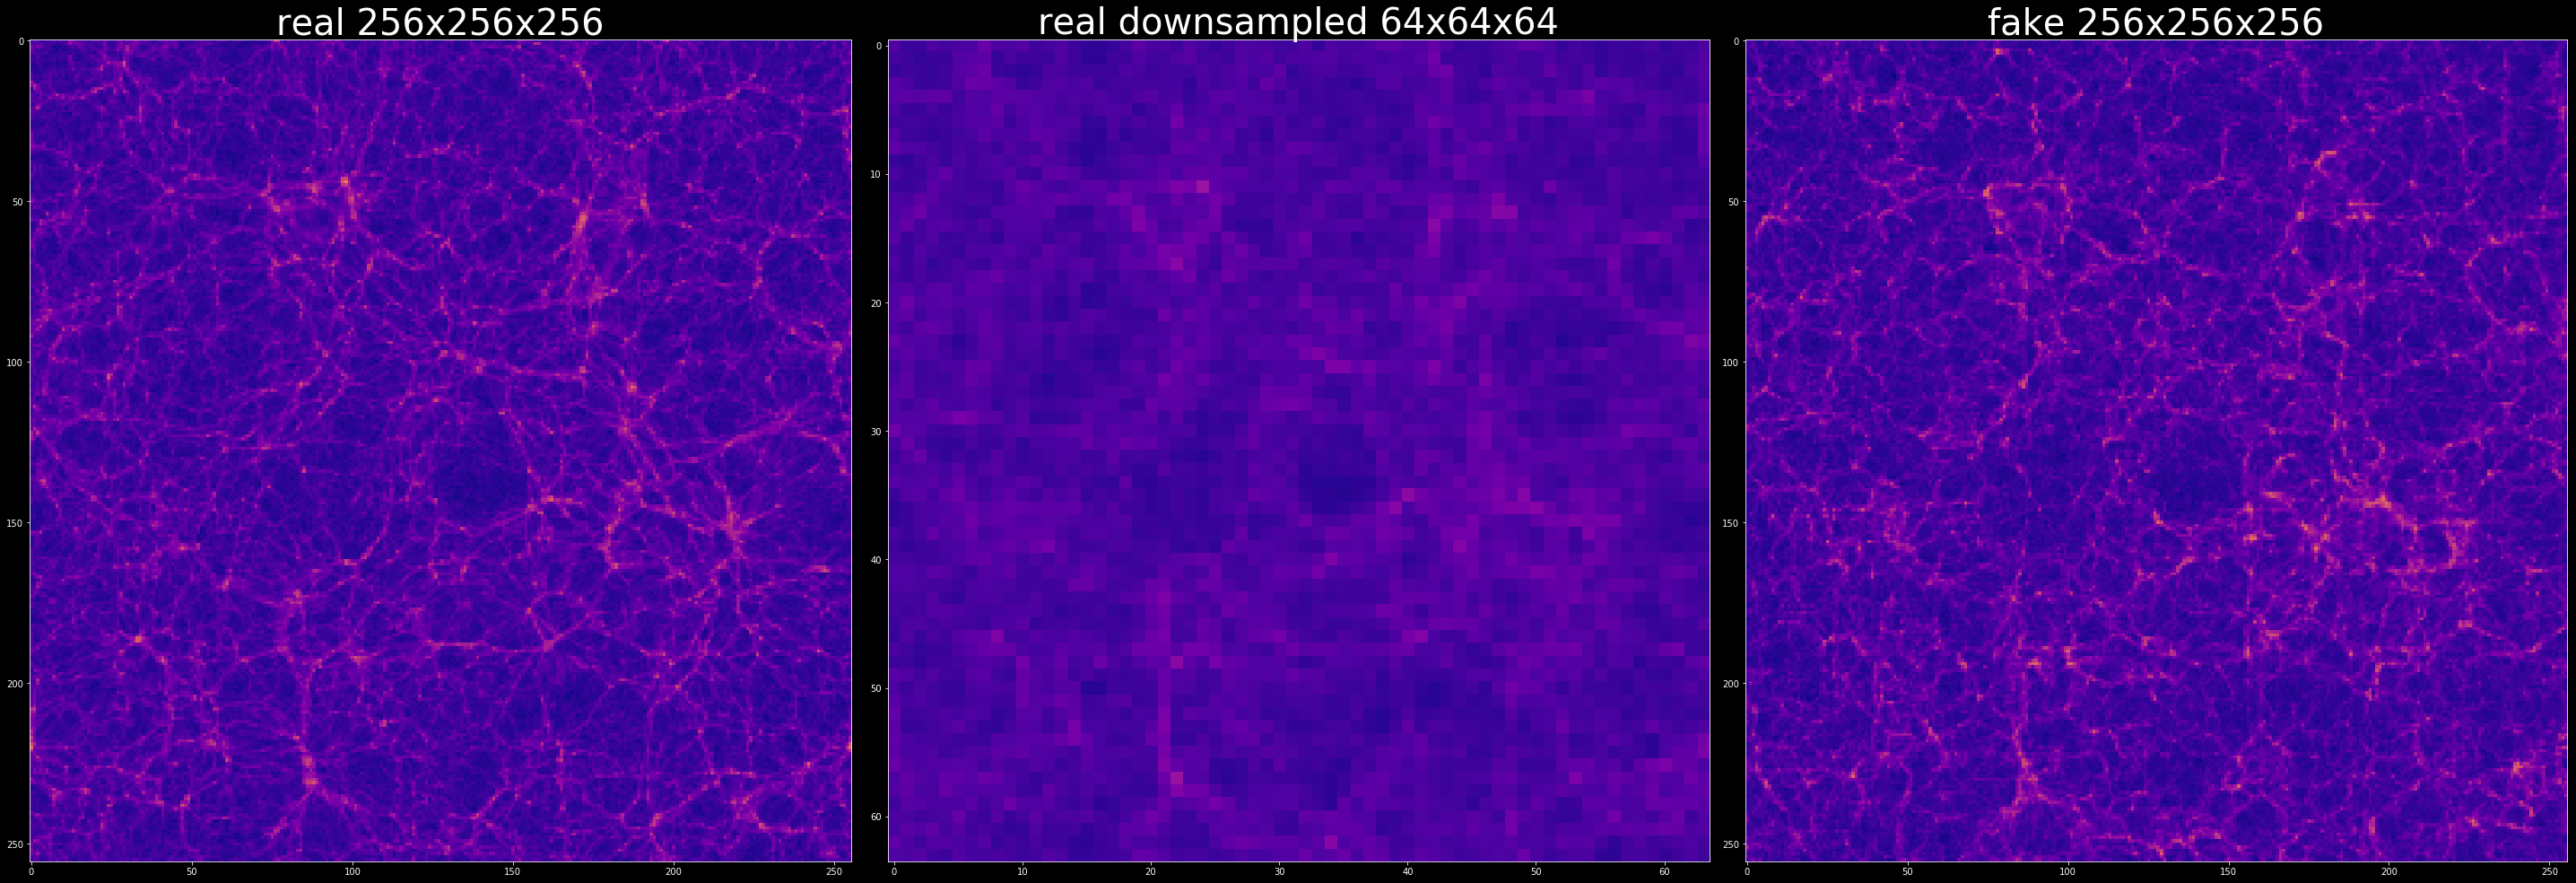

In [10]:
fake = l_fwd(fake_ln_256_raw[1, :, :, :])
real = l_fwd(real_ln_256_raw[1, :, :, :])
down = l_fwd(downsampled_ln_256_raw[1, :, :, :])
save_animation(real, fake, down, figsize=(40, 20), fps=16, format='mp4', output_file_name='Samples/final/resnet_64_to_256_log_norm/1st_256_samples_ckpt_116k_real.mp4', mail)

Log l2 PSD loss: 0.3901121689841729
L2 PSD loss: 9930.987848433962
Log l1 PSD loss: 0.5762159773658591
L1 PSD loss: 52.251438056275454


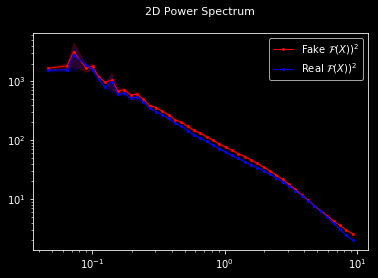

In [25]:
logl2, l2, logl1, l1 = evaluation.compute_and_plot_psd(real_ln_256_raw, fake_ln_256_raw, is_3d=True)

Log l2 Peak Count loss: 49.336510053030445
L2 Peak Count loss: 200085.1375
Log l1 Peak Count loss: 3.0970060554962195
L1 Peak Count loss: 348.875


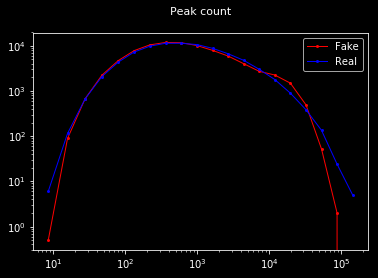

In [26]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_ln_256_raw, fake_ln_256_raw)

Log l2 Mass histogram loss: 43.77470670162927
L2 Peak Mass histogram: 1470545952.875
Log l1 Mass histogram loss: 2.145327323293348
L1 Mass histogram loss: 20016.25


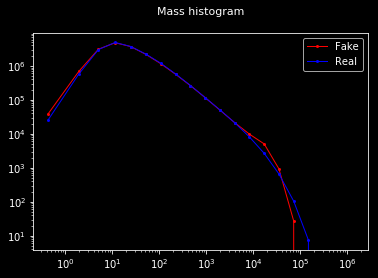

In [27]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_ln_256_raw, fake_ln_256_raw)

# log

In [3]:
real_l_256 = data.load.load_dataset_file(spix=256, resolution=256, Mpch=350, augmentation=False, shuffle=False, forward_map=l_fwd, is_3d=True).get_all_data()
real_l_256_raw = l_bkd(real_l_256)
print("Real shape: ", np.shape(real_l_256))

downsampled_l_256 = np.expand_dims(blocks.downsample(real_l_256[:2, :, :, :], s=4, is_3d=True), axis=4)
print('downsampled_l_256 shape=', downsampled_l_256.shape)

Loaded all 2 histograms only once in the beginning!
Real shape:  (2, 256, 256, 256)
Tensor down_sampler_out_3d_4:0 not found, hence creating the Op.
downsampled_l_256 shape= (2, 64, 64, 64, 1)


In [5]:
time_str = 'upscaling_GAN_3d_gen_8_disc_6_32_new_trans'
global_path = '../../up_scale_GAN_results/upscaling_GAN_3d/inception/upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/'
name = 'inception_upsampled_upscaling_GAN_3d_32'

params_256 = dict()
params_256['save_dir'] = global_path + name + '_' + time_str + 'checkpoints/'

resume, params_256 = utils.test_resume(try_resume, params_256)
print(params_256['curr_counter'])

params_256['summary_dir'] = global_path + params_256['name'] + '_' + time_str +'summary/'
params_256['save_dir'] = global_path + params_256['name'] + '_' + time_str + 'checkpoints/'

Resume, the training will start from the last iteration!
125000


In [8]:
wgan_256 = UpscaleCosmoGAN(params_256, upscale_WGAN_pixel_CNN, is_3d=True)
fake_l_256 = wgan_256.upscale_image(small=downsampled_l_256, is_3d=True, checkpoint=None)
utils.save_hdf5(fake_l_256, 'Samples/inception/upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/2_256_samples_ckpt_125k_real.h5')

Generator 
--------------------------------------------------
     The input X is of size (?, 8, 8, 8, 1)
     The input X is upsampled to size (?, 32, 32, 32, 1)
     The input z is of size (?, 32768)
     The input y is of size (?, 32, 32, 32, 7)
     Reshape z to (?, 32, 32, 32, 1)
     Concat X and z to (?, 32, 32, 32, 2)
conv_over_deconv= False
     Merge input y of size(?, 32, 32, 32, 7)
     Concat x and y to (?, 32, 32, 32, 9)
     0 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 96)
     1 Inception deconv(1x1,3x3,5x5) layer with 32 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 96)
     2 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 192)
     3 Inception deconv(1x1,3x3,5x5) layer with 64 channels
         ReLU applied
         Size of the variables: (?, 32, 32, 32, 192)
     4 Inception deconv

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../up_scale_GAN_results/upscaling_GAN_3d/inception/upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/inception_upsampled_upscaling_GAN_3d_32_upscaling_GAN_3d_gen_8_disc_6_32_new_transcheckpoints/inception_upsampled_upscaling_GAN_3d_32-125000
Checkpoint successfully loaded!
Total number of patches = 8*8*8 = 512
Current patch: column=1, row=1, height=1

Current patch: column=2, row=1, height=1

Current patch: column=3, row=1, height=1

Current patch: column=4, row=1, height=1

Current patch: column=5, row=1, height=1

Current patch: column=6, row=1, height=1

Current patch: column=7, row=1, height=1

Current patch: column=8, row=1, height=1

Current patch: column=1, row=2, height=1

Current patch: column=2, row=2, height=1

Current patch: column=3, row=2, height=1

Current patch: column=4, row=2, height=1

Current patch: column=5, row=2, height=1

Current patch: column=6, row=2, height=1

Current patch: column=7,

Current patch: column=3, row=8, height=3

Current patch: column=4, row=8, height=3

Current patch: column=5, row=8, height=3

Current patch: column=6, row=8, height=3

Current patch: column=7, row=8, height=3

Current patch: column=8, row=8, height=3

Current patch: column=1, row=1, height=4

Current patch: column=2, row=1, height=4

Current patch: column=3, row=1, height=4

Current patch: column=4, row=1, height=4

Current patch: column=5, row=1, height=4

Current patch: column=6, row=1, height=4

Current patch: column=7, row=1, height=4

Current patch: column=8, row=1, height=4

Current patch: column=1, row=2, height=4

Current patch: column=2, row=2, height=4

Current patch: column=3, row=2, height=4

Current patch: column=4, row=2, height=4

Current patch: column=5, row=2, height=4

Current patch: column=6, row=2, height=4

Current patch: column=7, row=2, height=4

Current patch: column=8, row=2, height=4

Current patch: column=1, row=3, height=4

Current patch: column=2, row=3, he

Current patch: column=7, row=8, height=6

Current patch: column=8, row=8, height=6

Current patch: column=1, row=1, height=7

Current patch: column=2, row=1, height=7

Current patch: column=3, row=1, height=7

Current patch: column=4, row=1, height=7

Current patch: column=5, row=1, height=7

Current patch: column=6, row=1, height=7

Current patch: column=7, row=1, height=7

Current patch: column=8, row=1, height=7

Current patch: column=1, row=2, height=7

Current patch: column=2, row=2, height=7

Current patch: column=3, row=2, height=7

Current patch: column=4, row=2, height=7

Current patch: column=5, row=2, height=7

Current patch: column=6, row=2, height=7

Current patch: column=7, row=2, height=7

Current patch: column=8, row=2, height=7

Current patch: column=1, row=3, height=7

Current patch: column=2, row=3, height=7

Current patch: column=3, row=3, height=7

Current patch: column=4, row=3, height=7

Current patch: column=5, row=3, height=7

Current patch: column=6, row=3, he

In [9]:
fake_l_256 = utils.load_hdf5('Samples/inception/upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/2_256_samples_ckpt_125k_real.h5')
fake_l_256_raw = l_bkd(fake_l_256)

[MoviePy] >>>> Building video Samples/inception/upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/2_256_samples_ckpt_125k_real.mp4
[MoviePy] Writing video Samples/inception/upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/2_256_samples_ckpt_125k_real.mp4


100%|█████████▉| 255/256 [00:35<00:00,  7.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Samples/inception/upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/2_256_samples_ckpt_125k_real.mp4 



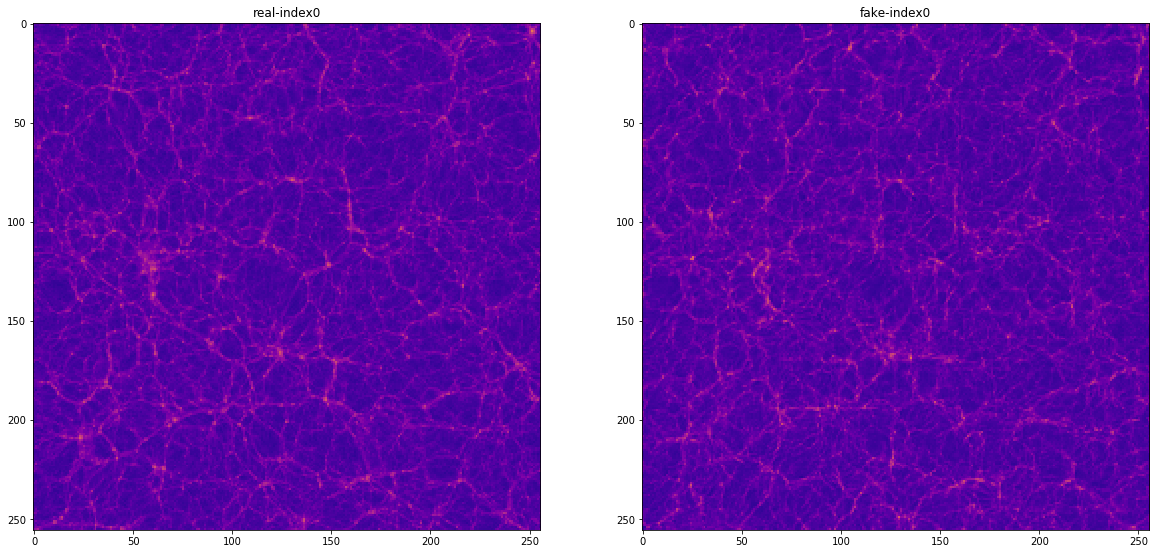

In [10]:
fake = fake_l_256[0, :, :, :]
real = real_l_256[0, :, :, :]
save_animation(real, fake, figsize=(20, 20), fps=5, format='mp4', output_file_name='Samples/inception/upsampled_upscaling_GAN_3d_32_gen_8_disc_6_new_trans/2_256_samples_ckpt_125k_real.mp4')

Log l2 PSD loss: 2.5766354129302784
L2 PSD loss: 10188.723310511064
Log l1 PSD loss: 1.3255374862017888
L1 PSD loss: 54.151513540713715


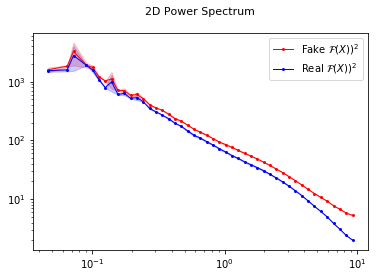

In [11]:
logl2, l2, logl1, l1 = evaluation.compute_and_plot_psd(real_l_256_raw, fake_l_256_raw, is_3d=True)

Log l2 Peak Count loss: 5.181314335429772
L2 Peak Count loss: 150098.4125
Log l1 Peak Count loss: 1.3566354234632465
L1 Peak Count loss: 283.575


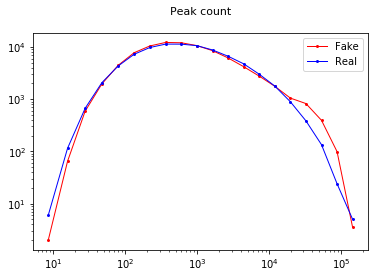

In [12]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_l_256_raw, fake_l_256_raw)

Log l2 Mass histogram loss: 3.4781650640196324
L2 Peak Mass histogram: 3342202668.6
Log l1 Mass histogram loss: 0.844379810154219
L1 Mass histogram loss: 25415.4


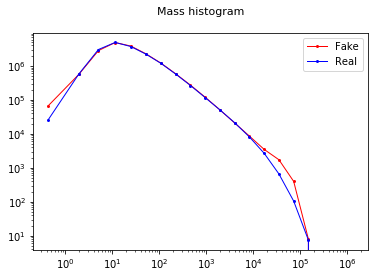

In [13]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_l_256_raw, fake_l_256_raw)

In [6]:
plt.style.use('default')